In [1]:
import requests

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm

import wbgapi as wb

import country_converter as coco
import logging
coco_logger = coco.logging.getLogger()
coco_logger.setLevel(logging.CRITICAL)



In [2]:
mailto = 'juan@youremailhere.com'

In [3]:
import plotly.express as px

In [4]:
def get_top_n(params, n=20):
    top_keys = []
    url = "https://api.openalex.org/works"
    r = requests.get(url, params=params)
    buckets = r.json()['group_by']
    for bucket in buckets:
        key = bucket['key']
        if key != 'unknown':
            top_keys.append(bucket['key'])
        if len(top_keys) == n:
            return top_keys
    return top_keys

def get_params(group_by, filters):
    params = {
        'mailto': mailto,
        'group_by': group_by,
    }
    if filters:
        params['filter'] = ','.join([f'{k}:{v}' for k, v in filters.items()])
    return params

def get_counts_by_year(group_by, filters=None, min_year=2000, max_year=2022, top_n=None):
    data = []
    url = "https://api.openalex.org/works"
    if filters is None:
        filters = {}
    for year in range(min_year,max_year+1):
        filters.update({'publication_year': year})
        params = get_params(group_by, filters)
        r = requests.get(url, params=params)
        group_by_results = r.json()['group_by']
        for bucket in group_by_results:
            data.append({
                'year': year,
                'key': bucket['key'],
                'key_display_name': bucket['key_display_name'],
                'n_works': bucket['count'],
            })
    df = pd.DataFrame(data)
    if top_n is not None:
        del filters['publication_year']
        params = get_params(group_by, filters)
        top_keys = get_top_n(params, n=top_n)
        df = df[df['key'].isin(top_keys)]
    return df

In [5]:
# Get the number of works GROUP BY type
group_by = 'type'
df_work_type_by_year = get_counts_by_year(group_by)

In [6]:
# Get the number of works with type == article GROUP BY source type
group_by = 'primary_location.source.type'
df_article_source_type_by_year = get_counts_by_year(group_by, {'type': 'article'})

# Change the key_display_name to have 'article-' in it, so that we can sort it out when merged with previous
df_article_source_type_by_year['key_display_name'] = df_article_source_type_by_year.key_display_name.map(lambda x: 'article-%s' % x)

# identify the most common source types, and change all the other source types to 'article-other' 
top_3_types = set(df_article_source_type_by_year.groupby('key_display_name')['n_works'].sum().nlargest(3).index)
df_article_source_type_by_year['key_display_name'] = df_article_source_type_by_year.key_display_name.map(lambda x: x if x in top_3_types else 'article-other')

In [18]:
# Some messy code to merge both and then calculate how many Source Type "unknown" 
# This is because # articles is greater than the Sum of the Group by Source Type (filtered by article)
tmp = df_work_type_by_year[df_work_type_by_year.key_display_name == 'article'].merge(df_article_source_type_by_year.groupby('year').sum(), left_on='year', right_on='year')
tmp['n_works'] = tmp['n_works_x'] - tmp['n_works_y']
tmp = tmp[['year', 'n_works']]
tmp['key'] = 'https://openalex.org/source-types/unknown'  # not really using, but to match up when concatenating
tmp['key_display_name'] = 'article-unknown'
df_article_source_type_by_year = pd.concat([df_article_source_type_by_year, tmp])
del tmp


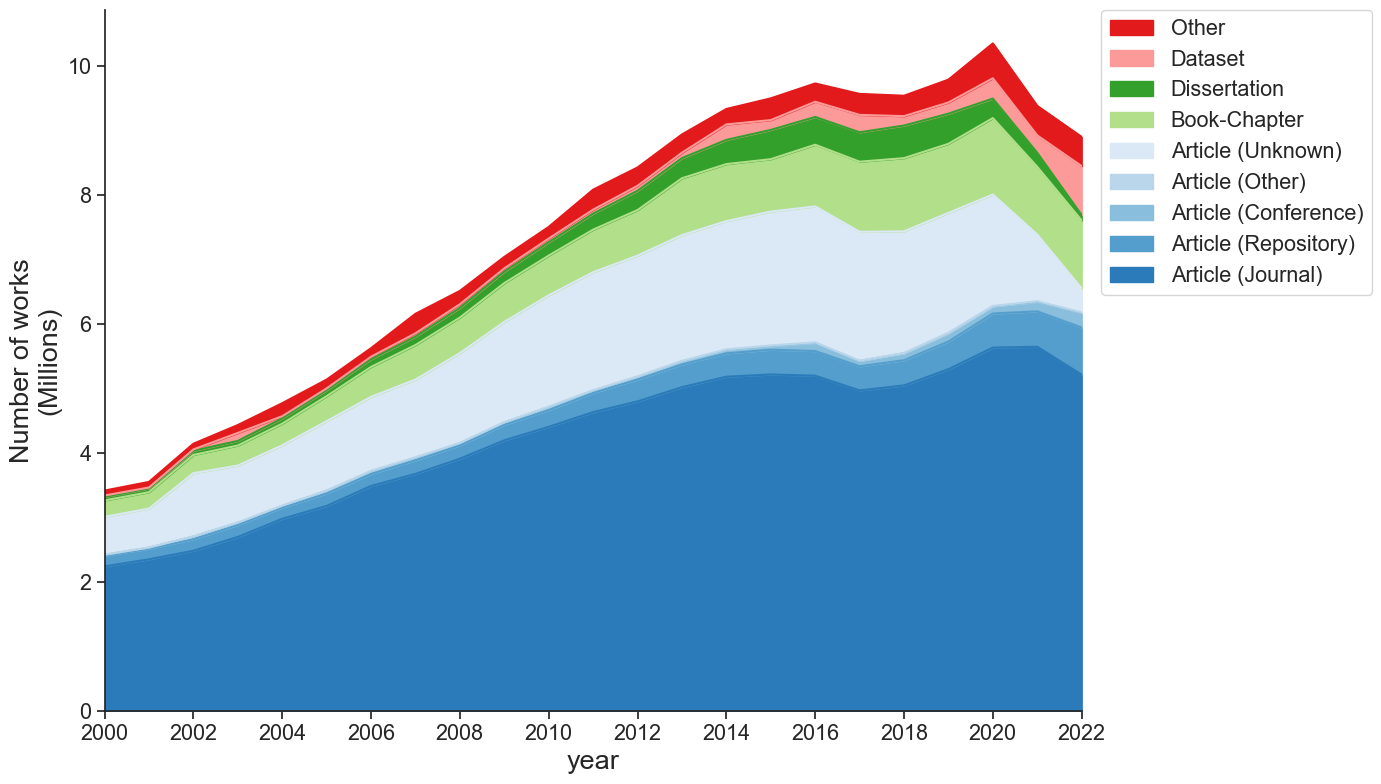

In [19]:
font_scale = 1.3
custom_params = {"axes.spines.right": False, 
                    "axes.spines.top": False, 
                    'axes.labelsize': 15 * font_scale, 
                    'axes.titlesize': 18 *font_scale,   
                    'xtick.labelsize': 12 * font_scale,  
                    'ytick.labelsize': 12 * font_scale,  
                    'legend.fontsize': 12 * font_scale  
                }
sns.set_theme(style="ticks", rc=custom_params)
blues = list(reversed(sns.color_palette("Blues")[0:5]))
color = blues + sns.color_palette("Paired")[2:]

fig, ax = plt.subplots(1, 1, figsize=(14, 8))

top_5_types = set(df_work_type_by_year.groupby('key_display_name')['n_works'].sum().nlargest(5).index)

data = df_work_type_by_year
data['key_display_name'] = data.key_display_name.map(lambda x: x if x in top_5_types else 'other')
# data.loc['key_display_name'] = data.key.map(lambda x: x if x != 'https://openalex.org/types/other' else 'other')


data = data[data.key_display_name != 'article']
data = pd.concat([data, df_article_source_type_by_year])

data = data.groupby(['year', 'key_display_name'])['n_works'].sum().reset_index()
data['n_works'] = data.n_works.divide(1000000)
# data.groupby('key_display_name').sum().sort_values('n_works', ascending=False).index
order = ['article-journal', 'article-repository', 'article-conference', 'article-other', 'article-unknown', 'book-chapter', 'dissertation', 'dataset', 'other']
data.pivot(index='year', columns='key_display_name', values='n_works')[order].plot(kind='area', color=color, ax=ax)

ax.set_ylabel('Number of works\n(Millions)')
ax.set_xticks(range(2000,2023,2))
ax.set_xlim([2000, 2022])

handles, labels = plt.gca().get_legend_handles_labels()
def format_labels(l):
    if l.startswith('article'):
        l = "{} ({})".format(l.split('-')[0], l.split('-')[1])
    return l.title()


plt.legend(reversed(handles), map(format_labels, reversed(labels)), bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

plt.tight_layout()
plt.savefig('figures/Figure 1. Number of Works per Year by Type and Subtype.png')



In [20]:
p_articles = df_work_type_by_year.groupby('key_display_name').sum()['n_works'].divide(df_work_type_by_year.groupby('key_display_name')['n_works'].sum().sum()).multiply(100)['article']
p_journal_articles = (df_article_source_type_by_year.groupby('key_display_name').sum()['n_works'] / df_article_source_type_by_year.groupby('key_display_name')['n_works'].sum().sum() * 100)['article-journal']

print("There are {:.1f}M works in OpenAlex published between 2000 and 2022, with a peak of {:.1f}M works published in {}.".
      format(df_work_type_by_year['n_works'].sum()/1000000,  df_work_type_by_year.groupby('year')['n_works'].sum().max()/1000000, df_work_type_by_year.groupby('year')['n_works'].sum().idxmax()))
print("The majority ({:.0f}%) of these works are classified as articles and, of these articles, the majority ({:.0f}%) are found in journals.".format(p_articles, p_journal_articles))


There are 172.8M works in OpenAlex published between 2000 and 2022, with a peak of 10.5M works published in 2020.
The majority (81%) of these works are classified as articles and, of these articles, the majority (70%) are found in journals.


In [21]:
p_articles = (df_work_type_by_year[df_work_type_by_year.year >= 2013].groupby('key_display_name').sum()['n_works'] / df_work_type_by_year[df_work_type_by_year.year >= 2013].groupby('key_display_name')['n_works'].sum().sum() * 100)['article']
p_journal_articles = (df_article_source_type_by_year[df_article_source_type_by_year.year >= 2013].groupby('key_display_name')['n_works'].sum() / df_article_source_type_by_year[df_article_source_type_by_year.year >= 2013].groupby('key_display_name')['n_works'].sum().sum() * 100)['article-journal']

print("The proportion classified as articles changes only slightly (to {:.0f}%) when considering only the most recent 10 years.".format(p_articles))


The proportion classified as articles changes only slightly (to 78%) when considering only the most recent 10 years.


In [22]:
# This should all be pretty straight forward once you cat update 
# get_counts_by_year to pull from the right data source
group_by = 'authorships.countries'
df_work_type_by_year = get_counts_by_year(group_by, top_n=10)

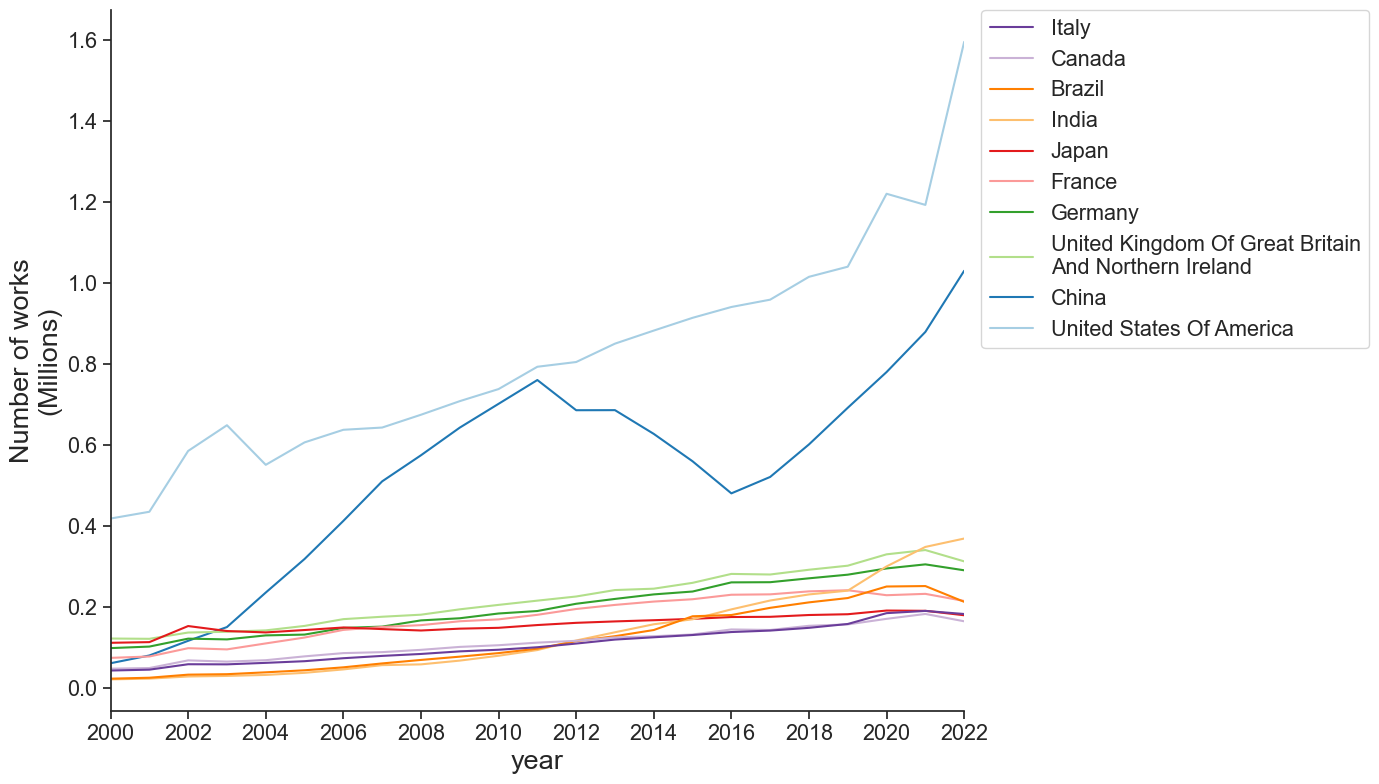

In [23]:
font_scale = 1.3
custom_params = {"axes.spines.right": False, 
                    "axes.spines.top": False, 
                    'axes.labelsize': 15 * font_scale, 
                    'axes.titlesize': 18 * font_scale,   
                    'xtick.labelsize': 12 * font_scale,  
                    'ytick.labelsize': 12 * font_scale,  
                    'legend.fontsize': 12 * font_scale  
                }
sns.set_theme(style="ticks", rc=custom_params)

color = sns.color_palette("Paired")

fig, ax = plt.subplots(1, 1, figsize=(14, 8))


data = df_work_type_by_year
data = data.groupby(['year', 'key_display_name'])['n_works'].sum().reset_index()
data['n_works'] = data.n_works.divide(1000000)
order = list(data.groupby('key_display_name').sum().sort_values('n_works', ascending=False).index)
data.pivot(index='year', columns='key_display_name', values='n_works')[order].plot(kind='line', color=color, ax=ax)


ax.set_ylabel('Number of works\n(Millions)')
ax.set_xticks(range(2000,2023,2))
ax.set_xlim([2000, 2022])

handles, labels = plt.gca().get_legend_handles_labels()
def format_labels(l):
    return l.replace(' and', '\nand').title()

plt.legend(reversed(handles), map(format_labels, reversed(labels)), bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

plt.tight_layout()
plt.savefig('figures/Figure 2. Number of Works per Year by Country.png')

